In [1]:
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, Xception
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten, Conv2D, concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,regularizers
import matplotlib.pyplot as plt
from keras import Sequential
from tensorflow.keras.callbacks import Callback
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam

In [2]:
#Dataset - https://www.kaggle.com/datasets/vfomenko/young-affectnet-hq/code

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d vfomenko/young-affectnet-hq

Dataset URL: https://www.kaggle.com/datasets/vfomenko/young-affectnet-hq
License(s): CC0-1.0
100% 5.05G/5.07G [01:07<00:00, 17.5MB/s]
100% 5.07G/5.07G [01:07<00:00, 80.7MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/young-affectnet-hq.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
count = 0
classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
for class_name in classes:
  count+=len(os.listdir(f'/content/{class_name}'))
  print(class_name, count)
  count = 0

anger 1822
contempt 1833
disgust 1740
fear 1839
happy 1862
neutral 1880
sad 1821
surprise 1851


In [ ]:
base_dir = '/content/'
classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
dataset = []
labels = []

for label_idx, class_name in enumerate(classes):
    class_dir = os.path.join(base_dir, class_name)
    for filename in os.listdir(class_dir):
        image = cv2.imread(os.path.join(class_dir, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = image / 255.0
        dataset.append(image)
        labels.append(label_idx)
dataset = np.array(dataset)
labels = np.array(labels)

print(dataset.shape)
print(labels.shape)

In [8]:
labels = to_categorical(labels, num_classes=len(classes))
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42, stratify=labels)

In [9]:
X_train

array([[[[1.        , 0.96078431, 0.96862745],
         [1.        , 0.99607843, 1.        ],
         [1.        , 0.99607843, 1.        ],
         ...,
         [0.99215686, 0.76862745, 0.90588235],
         [0.97647059, 0.74117647, 0.89411765],
         [0.98823529, 0.73333333, 0.88235294]],

        [[1.        , 0.98431373, 0.99215686],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 0.70196078, 0.8627451 ],
         [0.97254902, 0.6745098 , 0.84705882],
         [0.99215686, 0.72941176, 0.90196078]],

        [[1.        , 0.99607843, 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [0.97647059, 0.66666667, 0.81568627],
         [1.        , 0.70588235, 0.85882353],
         [0.99607843, 0.70980392, 0.88627451]],

        ...,

        [[0.99607843, 0.94117647, 0.94509804],
         [1.        , 0.94901961, 0.96078431]

In [10]:
y_train[0]

array([0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

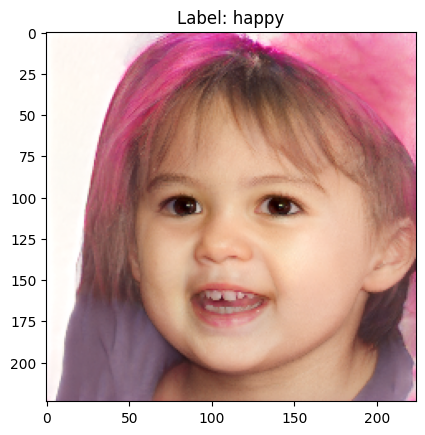

In [11]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])
plt.title(f"Label: {classes[np.argmax(y_train[0])]}")
plt.show()

In [12]:
X_train.shape

(11718, 224, 224, 3)

In [13]:
X_test.shape

(2930, 224, 224, 3)

In [14]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=64)
validation_generator = val_datagen.flow(X_test, y_test, batch_size=64)

In [32]:
input_shape = (224, 224, 3)
efficientnet_input = Input(shape=input_shape)
mobilenet_input = Input(shape=input_shape)

efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=efficientnet_input)
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=mobilenet_input)

efficientnet_features = Flatten()(efficientnet_base.output)
mobilenet_features = Flatten()(mobilenet_base.output)

combined_features = concatenate([efficientnet_features, mobilenet_features])
x = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01))(combined_features)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(8, activation='softmax')(x)

model = Model(inputs=[efficientnet_input, mobilenet_input], outputs=output)
efficientnet_base.trainable = False
mobilenet_base.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [24]:
!apt-get -qq install -y graphviz && pip install -q pydot

In [31]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
history = model.fit(
    [X_train, X_train],
    y_train,
    epochs=40,
    batch_size=64,
    validation_data=([X_test, X_test], y_test),
    callbacks=callbacks
)

Epoch 1/40
92/92 [==============================] - ETA: 0s - loss: 2.7223 - accuracy: 0.1594

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 [==============================] - 299s 3s/step - loss: 2.7223 - accuracy: 0.1594 - val_loss: 3.5396 - val_accuracy: 0.1324 - lr: 0.0010
Epoch 2/40
92/92 [==============================] - 289s 3s/step - loss: 2.2101 - accuracy: 0.2096 - val_loss: 1.8154 - val_accuracy: 0.2833 - lr: 0.0010
Epoch 3/40
92/92 [==============================] - 292s 3s/step - loss: 1.9690 - accuracy: 0.2520 - val_loss: 1.6739 - val_accuracy: 0.3474 - lr: 0.0010
Epoch 4/40
92/92 [==============================] - 296s 3s/step - loss: 1.8171 - accuracy: 0.2887 - val_loss: 1.5978 - val_accuracy: 0.3741 - lr: 0.0010
Epoch 5/40
92/92 [==============================] - 302s 3s/step - loss: 1.7211 - accuracy: 0.3153 - val_loss: 1.5476 - val_accuracy: 0.4027 - lr: 0.0010
Epoch 6/40
92/92 [==============================] - 300s 3s/step - loss: 1.6341 - accuracy: 0.3470 - val_loss: 1.5907 - val_accuracy: 0.3823 - lr: 0.0010
Epoch 7/40
92/92 [==============================] - 302s 3s/step - loss: 1.5763 - accur

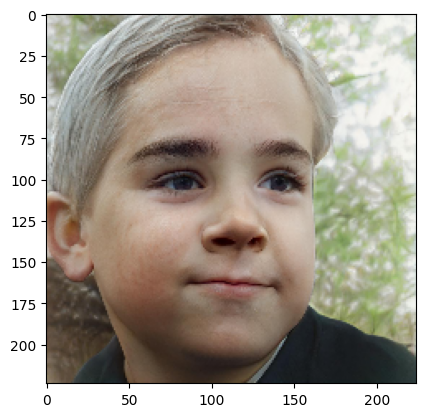

In [ ]:
plt.imshow(dataset[1])

1/1 [==============================] - 0s 134ms/step
[[0.19062775 0.12395354 0.13337961 0.20065168 0.00501044 0.00607798
  0.13923912 0.20105994]]
(224, 224, 3)


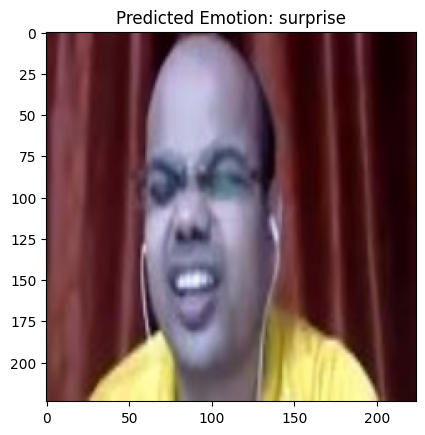

1/1 [==============================] - 0s 147ms/step
[[0.11096778 0.01794593 0.10480795 0.29079327 0.00669506 0.02233367
  0.12285853 0.32359788]]
(224, 224, 3)


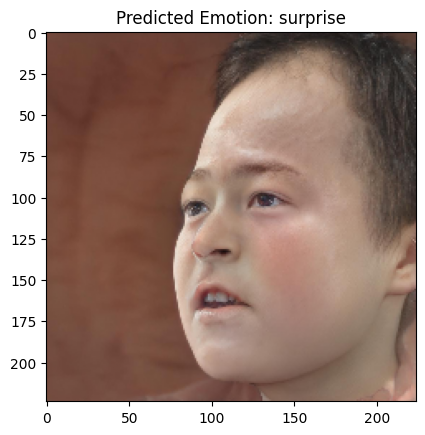

1/1 [==============================] - 0s 127ms/step
[[0.27138367 0.1539519  0.1984813  0.05906635 0.01752583 0.05977267
  0.20511983 0.03469847]]
(224, 224, 3)


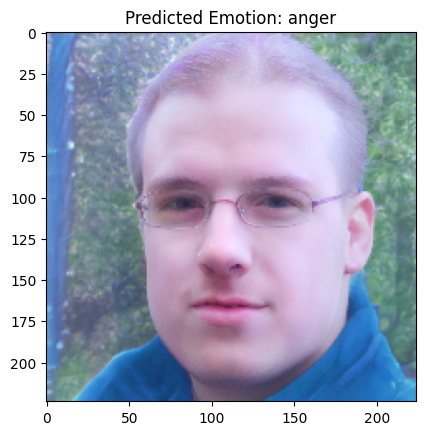

1/1 [==============================] - 0s 137ms/step
[[1.7332749e-03 1.6629768e-03 9.5350255e-04 9.1354194e-04 4.3225273e-02
  9.4616455e-01 1.4700646e-03 3.8767315e-03]]
(224, 224, 3)


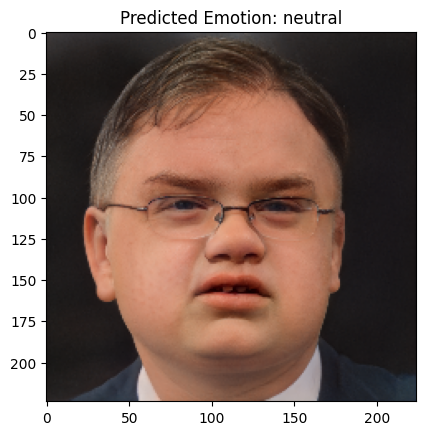

1/1 [==============================] - 0s 141ms/step
[[0.11926741 0.02784771 0.09929927 0.32955137 0.00235075 0.00325765
  0.25337306 0.1650528 ]]
(224, 224, 3)


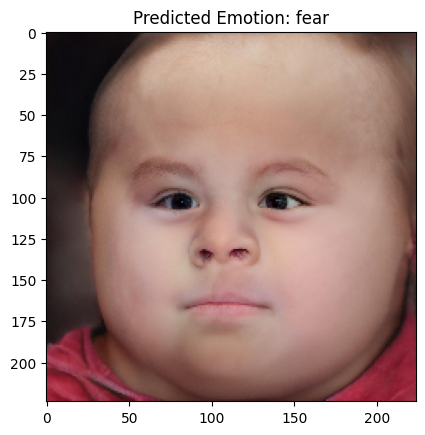

1/1 [==============================] - 0s 110ms/step
[[7.7694250e-07 2.8959414e-05 7.9872661e-06 5.4969751e-06 9.7201782e-01
  2.7875254e-02 1.3033593e-06 6.2371364e-05]]
(224, 224, 3)


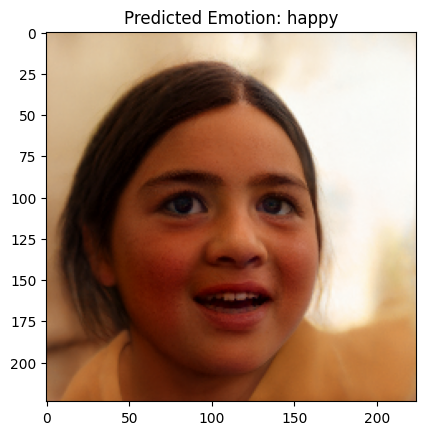

1/1 [==============================] - 0s 128ms/step
[[0.00077296 0.00264289 0.00111359 0.00218167 0.18291216 0.770662
  0.00113547 0.03857921]]
(224, 224, 3)


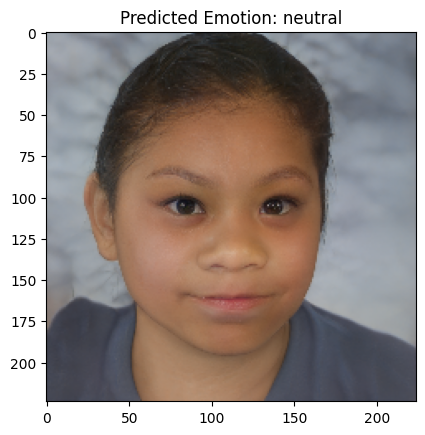

1/1 [==============================] - 0s 132ms/step
[[0.2314842  0.17217144 0.16179205 0.13494186 0.00316184 0.0060381
  0.22318374 0.06722667]]
(224, 224, 3)


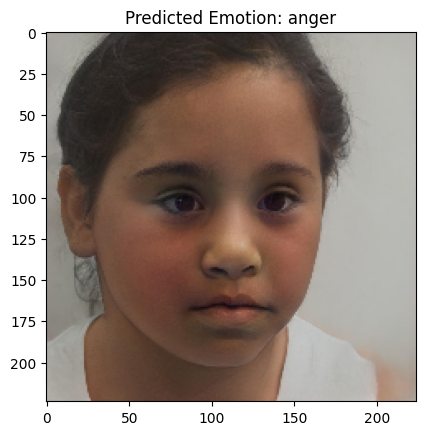

1/1 [==============================] - 0s 134ms/step
[[0.0269155  0.01082332 0.04171518 0.07000642 0.06950021 0.33986166
  0.0246032  0.41657454]]
(224, 224, 3)


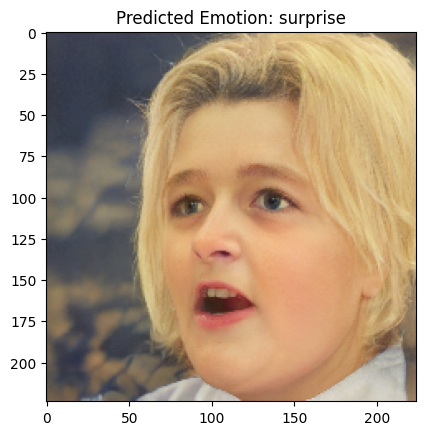

In [ ]:
classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return image

def predict_emotion(image):
    image = np.expand_dims(image, axis=0)
    prediction = model.predict([image, image])
    print(prediction)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_label = classes[predicted_class[0]]
    return predicted_label

x = ['/content/Screenshot 2021-05-04 192317  11.jpg', '/content/anger/10_image0000213.jpg','/content/contempt/10_ffhq_1.png','/content/disgust/10_ffhq_1.png','/content/fear/10_image0000694.jpg','/content/happy/10_ffhq_10.png','/content/neutral/10_ffhq_1.png','/content/sad/10_image0000093.jpg','/content/surprise/10_ffhq_101.png']

for i in x:

  image = preprocess_image(i)
  predicted_label = predict_emotion(image)
  print(image.shape)
  plt.imshow(image)
  plt.title(f"Predicted Emotion: {predicted_label}")
  plt.axis('on')
  plt.show()